# Pipeline

This pipeline is intended to simplify to whole process of loading a dataset, creating gaps of different types in it, imputing the missing data and evaluating the imputation method.
You may want to edit the cells preceded by an <span style="color: red">**EDIT:**</span> sign to fit your needs.

## Install dependencies

In [39]:
#!pip install openpyxl
#!pip install jupyterlab-widgets
#!pip install jsfileupload
#!pip install pyxlsb

## Set an arbitrary random state

In [1]:
import random

# TODO: this doesn't seem to work properly for functions other than random()
random.seed(7094400398089273)

## Load clean data

> The upload form only supports files up to 10Mo. For larger files, please upload them directly to JupyterHub and provide a relative link to them in the text input herebelow.

<span style="color:red">**EDIT**: customize the date parser function.</span>

In [2]:
from datetime import datetime

def custom_knmi_date_parser(hours: str) -> str:
    return datetime.fromtimestamp(1554109200) + timedelta(hours=int(hours))


def knmi_date_parser() -> str:
    # TODO
    pass


def factoryzero_date_parser(timestamp: int) -> str:
    return datetime.fromtimestamp(timestamp)


def date_parser(date) -> str:
    return custom_knmi_date_parser(date)

In [3]:
import io
import os
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import ipywidgets as widgets

# Index column name text input
default_index_column = 'time' # tweak this
index_column_input = widgets.Text(description='Index col:', value=default_index_column, continuous_update=False)
display(index_column_input)

# Create upload status text
upload_status = widgets.HTML(value='')

# Create the upload tab
upload_button = widgets.FileUpload(accept='.csv,.xlsx', multiple=False)
upload_form = widgets.VBox(
    children=[
        widgets.HTML(value='Upload file (limit 10Mo):'),
        upload_button,
        upload_status
    ]
)

# Create the file path tab
default_file_path = 'clean_temp_data.csv' # tweak this
filepath_text_input = widgets.Text(description='File path: ', value=default_file_path, continuous_update=False)
filepath_submit_button = widgets.Button(description='Submit')
filepath_form = widgets.VBox(
    children=[
        widgets.HTML(value='Relative file path:'),
        widgets.HBox(children=[
            filepath_text_input,
            filepath_submit_button
        ]),
        upload_status
    ]
)

# Create tabs container
tabs_titles = ['Upload', 'File path']
tabs_container = widgets.Tab(children=[upload_form, filepath_form])
for i in range(len(tabs_titles)):
    tabs_container.set_title(i, tabs_titles[i])
display(tabs_container)

# Create parsing status text
parsing_status = widgets.HTML(value='')
display(parsing_status)


# define global variables for later use
index_column: str = index_column_input.value
filename: str = None
buffer: bytes = None
df: pd.DataFrame = None
xl: pd.ExcelFile = None


# parsing utils
def parse_csv(buffer: bytes, separator: str = ','):
    global index_column, df
    data = io.StringIO(buffer.decode('utf-8'))
    df = pd.read_csv(data, sep=separator, index_col=index_column, converters={0: date_parser})


def parse_xlsx(buffer: bytes):
    global xl
    data = io.BytesIO(buffer)
    xl = pd.read_excel(data, converters={0: date_parser})
    

def parse_uploaded_file(filename:str, buffer: bytes):
    ext = os.path.splitext(filename)[1][1:]
    if ext == 'csv':
        return parse_csv(buffer)
    elif ext == 'xlsx':
        return parse_xlsx(buffer)
    else:
        raise Exception(f'Unsupported file extension: {ext}')


# define form event handlers
def on_index_column_change(evt):
    global index_column
    index_column = evt.new
index_column_input.observe(on_index_column_change, 'value')


def on_upload_change(evt):
    global filename, buffer
    filename = list(evt.owner.value.keys())[0]
    buffer = evt.owner.data[0]
    upload_status.value = 'Upload successful'
    parsing_status.value = 'Parsing file data...'
    parse_uploaded_file(filename, buffer)
    parsing_status.value = 'Parsing successful'
upload_button.observe(on_upload_change, names='_counter')


def on_filepath_submit(new: str):
    global filename, buffer
    filename = new
    upload_status.value = 'Upload starting...'
    with open(filename, 'rb') as file:
        buffer = file.read()
        upload_status.value = 'Upload successful'
    parsing_status.value = 'Parsing file data...'
    parse_uploaded_file(filename, buffer)
    parsing_status.value = 'Parsing successful'
filepath_submit_button.on_click(lambda evt:on_filepath_submit(filepath_text_input.value))

Text(value='time', continuous_update=False, description='Index col:')

HTML(value='')

## Create gaps of different sizes

<span style="color:red">**EDIT**: customize gaps sizes.</span>

In [5]:
# Define types of gaps we want to create: each row defines a type:
# [min gap sizes, max gap size, gaps ratio]
gaps_config = [
    [1,  6,   0.15],
    [6,  24,  0.05],
    [24, 72,  0.015],
    [72, 168, 0.005]
]

In [6]:
import numpy as np

gaps_indices = []


def create_gaps(df: pd.DataFrame, gaps_ratio: float, min_gap_size: int, max_gap_size: int):
    global gaps_indices

    indices_to_remove: [int] = []
    gaps_locations = sorted(random.sample(
        range(1, len(df) + 1), int(len(df) * gaps_ratio)))

    for gap_start in gaps_locations:
        # TODO: remove gaps too close to each other
        gap_end = min(gap_start + random.randrange(min_gap_size,
                      max_gap_size), len(df) - 1)
        indices_to_remove += [df.index[i] for i in range(gap_start, gap_end)]
    gaps_indices.append(indices_to_remove)
    return df.drop(index=indices_to_remove)


dfs_with_gaps: [pd.DataFrame] = []
for i in range(len(gaps_config)):
    min_gap_size, max_gap_size, gaps_ratio = gaps_config[i]
    dfs_with_gaps.append(create_gaps(
        df, gaps_ratio, min_gap_size, max_gap_size)) 

## Run the imputation

<span style="color:red">**EDIT**: create your own imputation strategy.</span>

In [14]:
from datetime import datetime, timedelta

# Using interpolation
def interpolate(df: pd.DataFrame, delta: timedelta, order: int) -> pd.DataFrame:
    resampler = df.resample(delta)
    upsampled = resampler.interpolate(method='spline', order=order)
    return upsampled


imputed_dfs: [pd.DataFrame] = []
for i in range(len(dfs_with_gaps)):
    imputed_dfs.append(interpolate(dfs_with_gaps[i], timedelta(hours=1), 2))

## Plot the imputation results

In [15]:
%matplotlib notebook

def plot_imputation(gapped: pd.DataFrame, imputed: pd.DataFrame, y_label: str, title="Untitled"):
    fig, ax = plt.subplots()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(y_label)
    plt.plot(df, c="green", label="Reference data")
    plt.plot(imputed, c="red", label="Imputed data")
    plt.plot(gapped, c="cyan", label="Data with gaps")
    ax.legend()
    plt.show()

<span style="color:red">**EDIT**: set plot title and y label.</span>

<IPython.core.display.Javascript object>


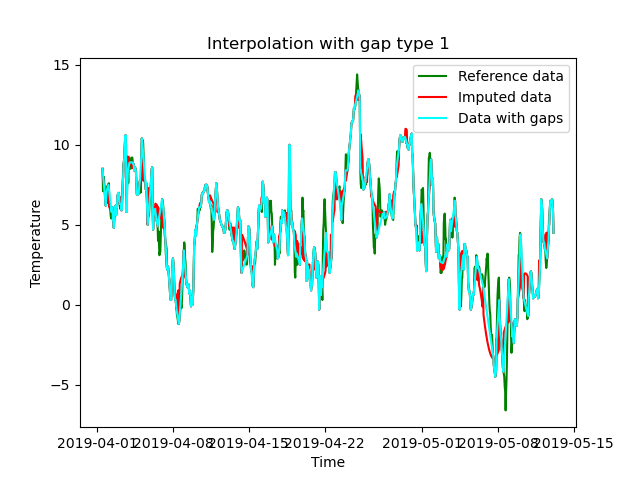

<IPython.core.display.Javascript object>


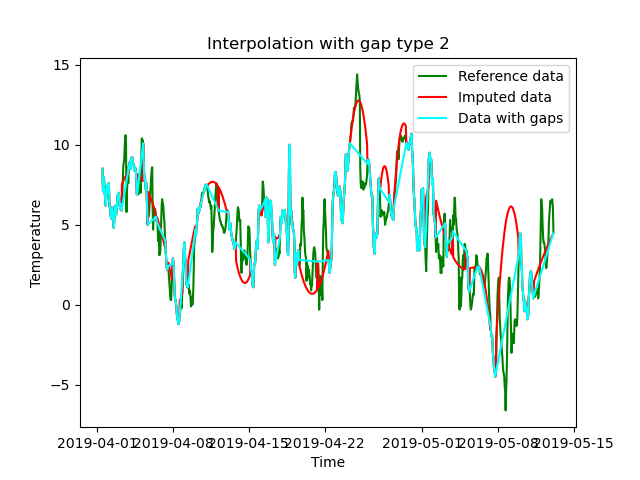

<IPython.core.display.Javascript object>


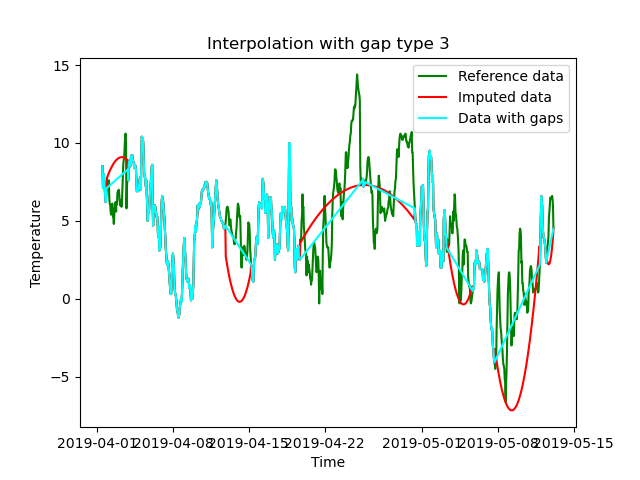

<IPython.core.display.Javascript object>


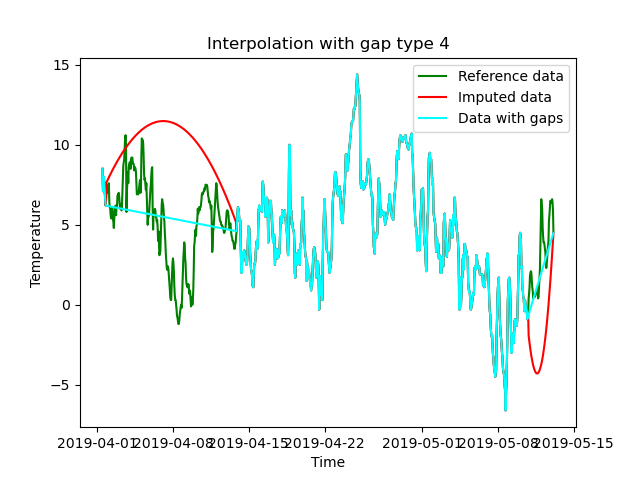

In [16]:
for i in range(len(imputed_dfs)):
    plot_imputation(dfs_with_gaps[i], imputed_dfs[i], "Temperature", f"Interpolation with gap type {i + 1}")

## Evaluate the imputation results

In [17]:
def pretty_print(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty_print(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


def plot_error_distribution(errors: [float], title: str):
    plt.subplots()
    plt.title(title)
    plt.hist(errors, 50, density=True, alpha=0.75)
    plt.show() 

Interpolation with gap type 1 [1;6]
	Mean Squared Error
		1.1879333845547462
	Raw Bias
		0.12114439039817013
	Absolute Raw Bias
		1.3839661705586574
	Percent Bias
		2.7578157263944725
	Sum
		650.464100162569
	Maximum
		5.5553871273808575
	Variance
		3.12410754733463



<IPython.core.display.Javascript object>


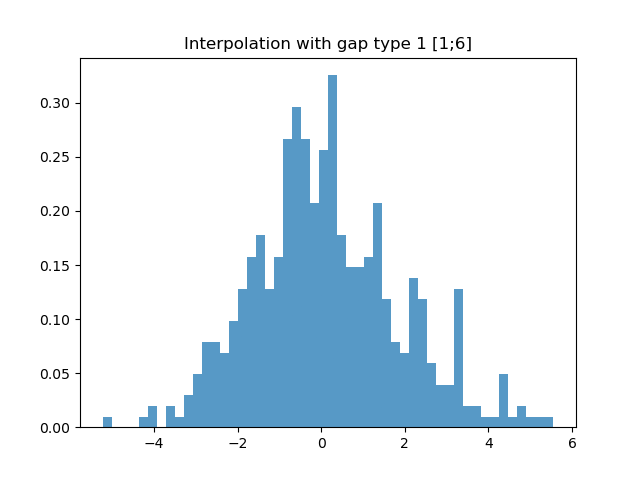

Interpolation with gap type 2 [6;24]
	Mean Squared Error
		3.959478888744566
	Raw Bias
		-0.5573041693860923
	Absolute Raw Bias
		1.9551858058906793
	Percent Bias
		13.171313567957377
	Sum
		1372.5404357352568
	Maximum
		3.883110491725712
	Variance
		6.955463390994172



<IPython.core.display.Javascript object>


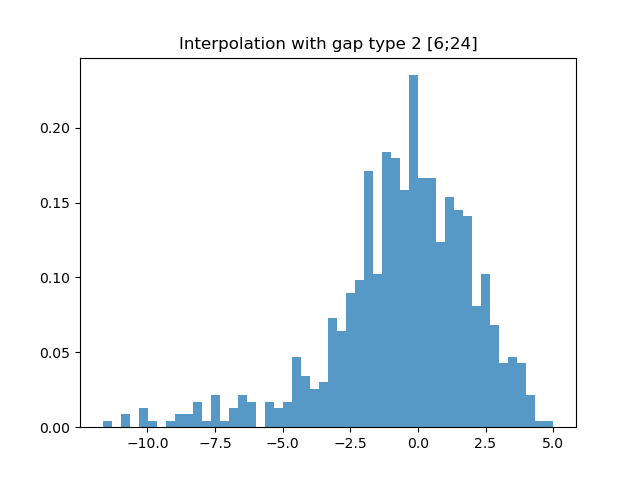

Interpolation with gap type 3 [24;72]
	Mean Squared Error
		6.361676924951713
	Raw Bias
		1.3667811473128135
	Absolute Raw Bias
		2.864367784550091
	Percent Bias
		31.783560562994428
	Sum
		2068.0735404451657
	Maximum
		10.720176871995056
	Variance
		10.50059533827017



<IPython.core.display.Javascript object>


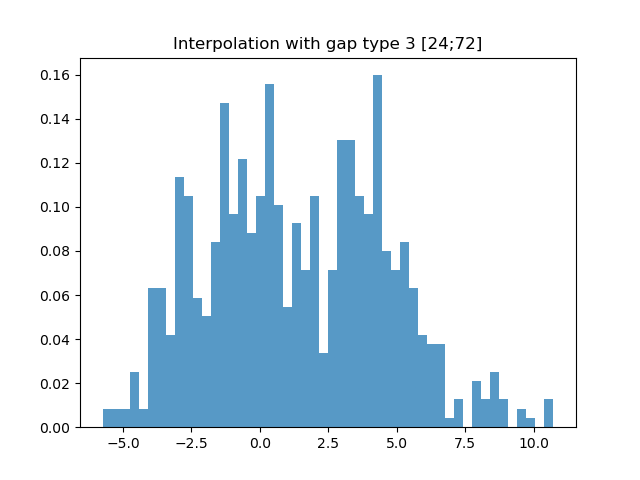

Interpolation with gap type 4 [72;168]
	Mean Squared Error
		10.772408579458794
	Raw Bias
		-4.398288620124794
	Absolute Raw Bias
		5.327602934472436
	Percent Bias
		98.66766744314268
	Sum
		3260.4929958971306
	Maximum
		10.320810376854332
	Variance
		20.81542582231928



<IPython.core.display.Javascript object>


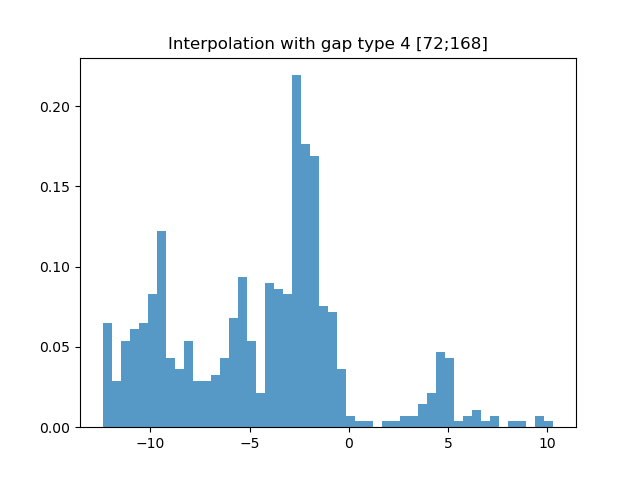

In [18]:
def mean_squared_error(ref: pd.DataFrame, pred: pd.DataFrame) -> float:
    return np.square(np.subtract(ref, pred)).mean().values[0]


def raw_bias(errors: [float]) -> float:
    return np.mean(errors)


def abs_raw_bias(abs_errors: [float]) -> float:
    return np.mean(abs_errors)

    
def percent_bias(ref_values: [float], pred_values: [float]) -> float:
    ref_mean = np.mean(ref_values)
    pred_mean = np.mean(pred_values)
    return 100 * abs((pred_mean - ref_mean) / ref_mean)


def sum_error(abs_errors: [float]) -> float:
    return np.sum(abs_errors)


def max_error(errors: [float]) -> float:
    res = 0
    for val in errors:
        res = val if abs(val) > res else res
    return res


def error_variance(errors: [float]) -> float:
    mean_error = raw_bias(errors)
    squared_diffs = [ (errors[i] - mean_error) ** 2 for i in range(len(errors)) ]
    return (1 / len(errors)) * np.sum(squared_diffs)


for i in range(len(imputed_dfs)):
    # tweak this
    ref_values = [df.iloc[:, 0][index] for index in gaps_indices[i]]
    pred_values = [imputed_dfs[i].iloc[:, 0][index]
                   for index in gaps_indices[i]]

    errors = [ref_values[i] - pred_values[i] for i in range(len(ref_values))]
    abs_errors = [abs(it) for it in errors]

    title = f"Interpolation with gap type {i + 1} [{gaps_config[i][0]};{gaps_config[i][1]}]"
    results = {
        "Mean Squared Error": mean_squared_error(df, imputed_dfs[i]),
        "Raw Bias": raw_bias(errors),
        "Absolute Raw Bias": abs_raw_bias(abs_errors),
        "Percent Bias": percent_bias(ref_values, pred_values),
        "Sum": sum_error(abs_errors),
        "Maximum": max_error(errors),
        "Variance": error_variance(errors)
    }

    print(title)
    pretty_print(results, indent=1)
    print("")

    plot_error_distribution(errors, title)